In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from src.dynamic_pricing_data_loader import cargar_y_preparar_datos

In [2]:
def Get_Data():
    # Obtener el directorio de trabajo actual (ruta principal del proyecto).
    ruta_principal = os.getcwd()

    # Construir la ruta al archivo de configuración "config/config.json".
    config_path = os.path.join(ruta_principal, "config", "config.json")

    # Llamar a la función externa que carga y realiza preprocesamiento inicial.
    Frame = cargar_y_preparar_datos(config_path, ruta_principal)

    # Seleccionar solo las columnas relevantes para el análisis.
    Frame = Frame[["FECHA_CORRIDA", "HORA_SALIDA_CORRIDA", "CLASE_SERVICIO", 'IVA_TARIFA_BASE_TRAMO',
    "PAX_SUBEN", "TARIFA_BASE_TRAMO",'FECHA_OPERACION', 'HORA_OPERACION','VENTA','DISPONIBILIDAD_TRAMO',
    'HORAS_ANTICIPACION','ORIGEN', 'DESTINO','TIPO_CLIENTE','NUM_ASIENTO'
                  ]].copy()

    return Frame

In [3]:
def Prepare_Data():
    df=Get_Data()
    # Se filtra el DataFrame para incluir solo ventas mayores que cero.
    df = df[df['VENTA'] > 0]
    df['FECHA_OPERACION'] = pd.to_datetime(df['FECHA_OPERACION'])
    fecha_maxima = df['FECHA_OPERACION'].max()
    Df = df[df['FECHA_OPERACION'] < fecha_maxima].copy()
    df['FECHA_CORRIDA'] = pd.to_datetime(
        df['FECHA_CORRIDA']
    )
    
    df["HORA_SALIDA_CORRIDA"] = pd.to_datetime(
        df["HORA_SALIDA_CORRIDA"]
    ).dt.time
    
    df['TBT']= df['TARIFA_BASE_TRAMO']-df['IVA_TARIFA_BASE_TRAMO']
    df['%_dif_TBT_Venta']= (df['TBT']-df['VENTA'])/df['TBT']
    df['TIPO_CLASE'] = np.where(
        df['CLASE_SERVICIO'].astype(str).str.contains('DOS PISOS', case=False, na=False),
        'DOS',
        'UNO'
    )
    return df 

In [4]:
def Data4RedNeuronal():
    df=Prepare_Data()
    df_total= pd.DataFrame()
    df_total['Origen-Destino'] = df['ORIGEN'].astype(str) + '-' + df['DESTINO'].astype(str)
    df_total['DiaSemana_Corrida']=df['FECHA_CORRIDA'].dt.dayofweek
    df_total['Hora_Corrida']=df['FECHA_CORRIDA'].dt.hour
    df_total[['NUM_ASIENTO','HORAS_ANTICIPACION','%_dif_TBT_Venta']]=df[['NUM_ASIENTO','HORAS_ANTICIPACION','%_dif_TBT_Venta']].copy()
    df_total['Mes_Corrida']=df['FECHA_CORRIDA'].dt.month
    df_total['Buen_Dia'] = df['FECHA_CORRIDA'].dt.dayofweek.isin([4,5,6,0]).astype(int)
    df_total['Buena_Hora'] = df['FECHA_CORRIDA'].dt.hour.isin([23,17,18,19,20]).astype(int)
    df_total['Buen_Mes'] = df['FECHA_CORRIDA'].dt.month.isin([3,4,5,6]).astype(int)
    df_total['Buen_Asiento'] = df['NUM_ASIENTO'].isin([1,2,3,4,5,6,7,8,9,10]).astype(int)
    # Crea un nuevo DataFrame con las variables dummy (codificación one-hot)
    df_dummies = pd.get_dummies(
        df['TIPO_CLIENTE'],
        prefix='TIPO_CLIENTE', # Prefijo para las nuevas columnas (ej: TIPO_CLIENTE_A)
        drop_first=False        # Elimina la primera categoría para evitar multicolinealidad
    ).astype(int)
    
    # Crea un nuevo DataFrame con las variables dummy (codificación one-hot)
    df_dummies1 = pd.get_dummies(
        df['TIPO_CLASE'],
        prefix='PISO', 
        drop_first=False
    ).astype(int)
    
    # Une las nuevas columnas dummy al DataFrame original
    df_total = pd.concat([df_total, df_dummies,df_dummies1], axis=1)
    df_total['VENTA']=df['VENTA'].copy()

    return df_total

In [5]:
FrameN=Data4RedNeuronal()

Memoria usada antes: 622.78 MB
Memoria usada después: 121.06 MB
Reducción: 80.6%


In [6]:
FrameN.head()

,Origen-Destino,DiaSemana_Corrida,Hora_Corrida,NUM_ASIENTO,HORAS_ANTICIPACION,%_dif_TBT_Venta,Mes_Corrida,Buen_Dia,Buena_Hora,Buen_Mes,Buen_Asiento,TIPO_CLIENTE_AGENCIA,TIPO_CLIENTE_CALL CENTER,TIPO_CLIENTE_INTERNET,TIPO_CLIENTE_NULL,TIPO_CLIENTE_TAQUILLA,PISO_DOS,PISO_UNO,VENTA
0,MEXN-GDLJ,6,0,15,8.0,-0.080864,1,1,0,0,0,0,0,1,0,0,1,0,888.359985
1,MEXN-GDLJ,1,0,28,59.0,-0.071422,1,0,0,0,0,0,0,1,0,0,1,0,880.599976
2,MEXN-GDLJ,1,0,28,59.0,-0.071422,1,0,0,0,0,0,0,1,0,0,1,0,880.599976
3,MEXN-GDLJ,1,0,29,59.0,-0.071422,1,0,0,0,0,0,0,1,0,0,1,0,880.599976
4,MEXN-GDLJ,1,0,29,59.0,-0.071422,1,0,0,0,0,0,0,1,0,0,1,0,880.599976


In [7]:
FrameN.shape

(355594, 19)

In [8]:
#FrameN.to_excel('PruebaData4RedN.xlsx')

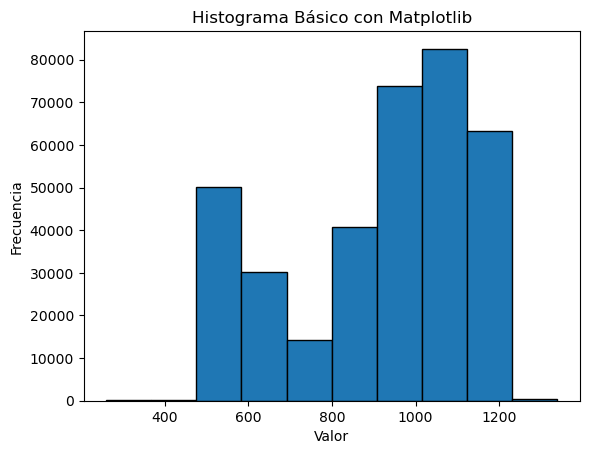

In [9]:
datos=FrameN['VENTA']
plt.hist(datos, bins=10, edgecolor='black')

# 3. Añadir etiquetas y título
plt.title('Histograma Básico con Matplotlib')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# 4. Mostrar el gráfico
plt.show()

In [10]:
df= FrameN.copy()

In [11]:
df.shape

(355594, 19)

In [12]:
# Definir la variable objetivo (Y)
Y = df['VENTA']

Bandera=False
if Bandera:
    # Aplicar la transformación logarítmica a Y
    Y_log = np.log(Y)
else:
    Y_log = Y.copy()

# Eliminar la variable VENTA del dataframe de features (X)
X = df.drop('VENTA', axis=1)

In [13]:
X.shape

(355594, 18)

In [14]:
X.head(3)

,Origen-Destino,DiaSemana_Corrida,Hora_Corrida,NUM_ASIENTO,HORAS_ANTICIPACION,%_dif_TBT_Venta,Mes_Corrida,Buen_Dia,Buena_Hora,Buen_Mes,Buen_Asiento,TIPO_CLIENTE_AGENCIA,TIPO_CLIENTE_CALL CENTER,TIPO_CLIENTE_INTERNET,TIPO_CLIENTE_NULL,TIPO_CLIENTE_TAQUILLA,PISO_DOS,PISO_UNO
0,MEXN-GDLJ,6,0,15,8.0,-0.080864,1,1,0,0,0,0,0,1,0,0,1,0
1,MEXN-GDLJ,1,0,28,59.0,-0.071422,1,0,0,0,0,0,0,1,0,0,1,0
2,MEXN-GDLJ,1,0,28,59.0,-0.071422,1,0,0,0,0,0,0,1,0,0,1,0


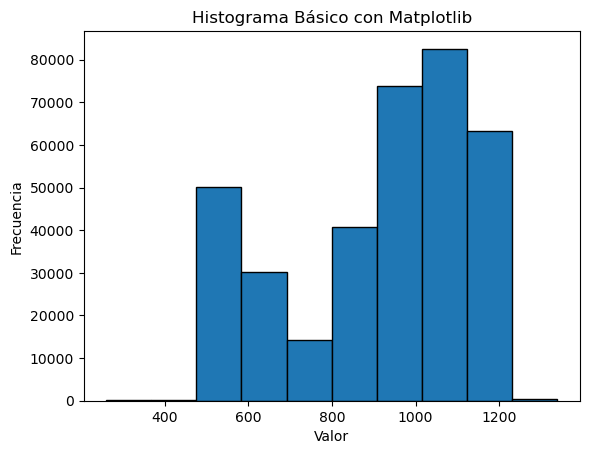

In [15]:
plt.hist(Y_log, bins=10, edgecolor='black')

# 3. Añadir etiquetas y título
plt.title('Histograma Básico con Matplotlib')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# 4. Mostrar el gráfico
plt.show()

In [16]:
categorical_features= 'Origen-Destino'
df_ohe = pd.get_dummies(X[categorical_features]).astype(int)

# Columnas numéricas que necesitan Estandarización
# Excluimos las binarias/dummies que ya están bien escaladas (0 o 1)
numeric_features = [
    'DiaSemana_Corrida', 'Hora_Corrida', 'NUM_ASIENTO', 
    'HORAS_ANTICIPACION', '%_dif_TBT_Venta', 'Mes_Corrida'
]

# Columnas binarias (se dejan pasar sin transformación)
binary_features = [col for col in X.columns if col not in [categorical_features] + numeric_features]

indice_correcto = X[numeric_features].index # o df_ohe.index

scaler = StandardScaler()
# 2. Convierte el array escalado (NumPy) a DataFrame, ASIGNANDO el índice correcto
X_escalado_array = scaler.fit_transform(X[numeric_features])
X_escalado = pd.DataFrame(X_escalado_array, 
                          index=indice_correcto, # <-- ¡CLAVE!
                          columns=numeric_features)

X_processed= pd.concat([df_ohe, X_escalado,X[binary_features]], axis=1)

In [17]:
X_processed

,MEXN-GDLJ,TEPO-GDLJ,DiaSemana_Corrida,Hora_Corrida,NUM_ASIENTO,HORAS_ANTICIPACION,%_dif_TBT_Venta,Mes_Corrida,Buen_Dia,Buena_Hora,Buen_Mes,Buen_Asiento,TIPO_CLIENTE_AGENCIA,TIPO_CLIENTE_CALL CENTER,TIPO_CLIENTE_INTERNET,TIPO_CLIENTE_NULL,TIPO_CLIENTE_TAQUILLA,PISO_DOS,PISO_UNO
0,1,0,1.407725,0.0,-0.213164,-0.403893,-0.473487,-1.585304,1,0,0,0,0,0,1,0,0,1,0
1,1,0,-1.014245,0.0,1.067697,-0.150333,-0.431424,-1.585304,0,0,0,0,0,0,1,0,0,1,0
2,1,0,-1.014245,0.0,1.067697,-0.150333,-0.431424,-1.585304,0,0,0,0,0,0,1,0,0,1,0
3,1,0,-1.014245,0.0,1.166225,-0.150333,-0.431424,-1.585304,0,0,0,0,0,0,1,0,0,1,0
4,1,0,-1.014245,0.0,1.166225,-0.150333,-0.431424,-1.585304,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391500,1,0,-1.014245,0.0,1.264753,-0.438695,-1.138633,1.078053,0,0,0,0,0,0,0,0,1,1,0
391501,1,0,-1.014245,0.0,-0.804330,-0.438695,-1.138633,1.078053,0,0,0,1,0,0,0,0,1,1,0
391502,1,0,-1.014245,0.0,0.279475,-0.438695,-1.138633,1.078053,0,0,0,0,0,0,0,0,1,1,0
391503,1,0,-1.014245,0.0,-0.213164,-0.438695,-1.138633,1.078053,0,0,0,0,0,0,0,0,1,1,0


In [18]:
# División del 80% para entrenamiento y 20% para prueba
X_train, X_test, Y_train_log, Y_test_log = train_test_split(
    X_processed, 
    Y_log, 
    test_size=0.2, 
    random_state=42 # Para asegurar resultados reproducibles
)

# Ahora tenemos nuestros 4 conjuntos listos para la red neuronal:
# X_train: Features de entrenamiento (escalados y codificados)
# X_test: Features de prueba (escalados y codificados)
# Y_train_log: Precios de entrenamiento (transformados con log)
# Y_test_log: Precios de prueba (transformados con log)

# --- RESPUESTA A TU PREGUNTA DE TAMAÑO ---
# Este es el número de columnas de tu X_train, que necesitas para la capa de entrada:
input_feature_count = X_train.shape[1] 

print(f"\n--- Resumen de la División ---")
print(f"Número total de features (columnas) para la red neuronal: {input_feature_count}")
print(f"Tamaño de X_train (Entrenamiento): {X_train.shape}")
print(f"Tamaño de X_test (Prueba): {X_test.shape}")
print(f"Tamaño de Y_train_log (Objetivo de Entrenamiento): {Y_train_log.shape}")


--- Resumen de la División ---
Número total de features (columnas) para la red neuronal: 19
Tamaño de X_train (Entrenamiento): (284475, 19)
Tamaño de X_test (Prueba): (71119, 19)
Tamaño de Y_train_log (Objetivo de Entrenamiento): (284475,)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# --- 1. Definir el número de features de entrada ---
# (Esto debe ser el número de columnas de tu X_train después del OHE y estandarización)
input_shape = X_train.shape[1] 

# --- 2. CONSTRUCCIÓN DEL MODELO ---
model = Sequential([
    # Capa Oculta 1
    Dense(128, activation='relu', input_shape=(input_shape,)),
    
    # Capa Oculta 2 (Regularización para evitar overfitting)
    # Aquí puedes añadir 'Dropout' si notas que el modelo se sobreajusta
    Dense(64, activation='relu'), 
    
    # Capa de Salida: 1 neurona y activación lineal para regresión
    Dense(1, activation='linear') 
])

# --- 3. COMPILACIÓN DEL MODELO ---
model.compile(
    optimizer='adam',
    loss='mse',           # Función de pérdida: Error Cuadrático Medio
    metrics=['mae', 'mse']  # Métricas a monitorear: MAE y MSE
)

# --- 4. ENTRENAMIENTO (Ejemplo) ---
history = model.fit(
    X_train, 
    Y_train_log,  # ¡Usamos la variable VENTA transformada con logaritmo!
    epochs=50, 
    batch_size=32, 
    validation_split=0.2, # Usamos el 20% para validación interna
    verbose=1
)

print(model.summary())

Epoch 1/50
7112/7112 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 19237.1152 - mae: 62.9578 - mse: 19237.1152 - val_loss: 2486.4609 - val_mae: 39.2495 - val_mse: 2486.4609
Epoch 2/50
7112/7112 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 2266.1055 - mae: 37.0330 - mse: 2266.1055 - val_loss: 2079.5469 - val_mae: 34.1406 - val_mse: 2079.5469
Epoch 3/50
7112/7112 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 2020.5642 - mae: 33.4773 - mse: 2020.5642 - val_loss: 1984.9460 - val_mae: 32.4289 - val_mse: 1984.9460
Epoch 4/50
7112/7112 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 1951.9083 - mae: 32.4256 - mse: 1951.9083 - val_loss: 1942.3087 - val_mae: 32.4985 - val_mse: 1942.3087
Epoch 5/50
7112/7112 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 1893.9346 - mae: 31.6023 - mse: 1893.9346 - val_loss: 1876.1835 - val_mae: 31.5188 - val_mse: 1876.1835
Epoch 6/50
7112/7112 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 1840.6354 - mae: 30.8710 - mse: 1840.6354 - val_loss: 1805.7228 - val_mae: 30.0558 - val_mse: 1805.7

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,645 (127.52 KB)

 Trainable params: 10,881 (42.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,764 (85.02 KB)

None


In [20]:
# 'model' es tu red neuronal entrenada
# 'X_test' son tus features de prueba (escalados y codificados)
Y_pred_log = model.predict(X_test)

if Bandera:
    # Revertir la predicción logarítmica a la escala de precio real
    Y_pred_real = np.exp(Y_pred_log)
    # Revertir los valores reales de prueba (Y_test_log) a la escala de precio real
    # Esto es para compararlos directamente
    Y_test_real = np.exp(Y_test_log) 
else:
    Y_pred_real= Y_pred_log.copy()
    Y_test_real = Y_test_log.copy()



2223/2223 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [21]:
from sklearn.metrics import mean_absolute_error

# Calcular el MAE real
mae_real = mean_absolute_error(Y_test_real, Y_pred_real)

print(f"\nEl Error Absoluto Medio (MAE) final es de: {mae_real:,.2f} [Moneda]")


El Error Absoluto Medio (MAE) final es de: 24.80 [Moneda]


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

#  Calcular el Error Cuadrático Medio (MSE)
mse_real = mean_squared_error(Y_test_real, Y_pred_real)

# Calcular la Raíz del Error Cuadrático Medio (RMSE)
#    La RMSE es simplemente la raíz cuadrada del MSE
rmse_real = np.sqrt(mse_real)

print(f"\nLa Raíz del Error Cuadrático Medio (RMSE) final es de: {rmse_real:,.2f} [Moneda]")

In [22]:
def DataForecasting(df,FrameN):

    df['TIPO_CLASE'] = np.where(
        df['CLASE_SERVICIO'].astype(str).str.contains('DOS PISOS', case=False, na=False),
        'DOS',
        'UNO'
    )

    df_total = pd.DataFrame(columns=FrameN.columns)
    print(df_total.shape)
    
    df_total['Origen-Destino'] = df['ORIGEN'].astype(str) + '-' + df['DESTINO'].astype(str)
    df_total['DiaSemana_Corrida']=df['FECHA_CORRIDA'].dt.dayofweek
    df_total['Hora_Corrida']=df['FECHA_CORRIDA'].dt.hour
    df_total[['NUM_ASIENTO','HORAS_ANTICIPACION']]=df[['NUM_ASIENTO','HORAS_ANTICIPACION']].copy()
    df_total['%_dif_TBT_Venta']=FrameN['%_dif_TBT_Venta'].mean()
    df_total['Mes_Corrida']=df['FECHA_CORRIDA'].dt.month
    df_total['Buen_Dia'] = df['FECHA_CORRIDA'].dt.dayofweek.isin([4,5,6,0]).astype(int)
    df_total['Buena_Hora'] = df['FECHA_CORRIDA'].dt.hour.isin([23,17,18,19,20]).astype(int)
    df_total['Buen_Mes'] = df['FECHA_CORRIDA'].dt.month.isin([3,4,5,6]).astype(int)
    df_total['Buen_Asiento'] = df['NUM_ASIENTO'].isin([1,2,3,4,5,6,7,8,9,10]).astype(int)
    # Crea un nuevo DataFrame con las variables dummy (codificación one-hot)
    df_dummies = pd.get_dummies(
        df['TIPO_CLIENTE'],
        prefix='TIPO_CLIENTE', # Prefijo para las nuevas columnas (ej: TIPO_CLIENTE_A)
        drop_first=False        # Elimina la primera categoría para evitar multicolinealidad
    ).astype(int)

    df_total[df_dummies.columns]= df_dummies[df_dummies.columns].copy()
    # Crea un nuevo DataFrame con las variables dummy (codificación one-hot)
    df_dummies1 = pd.get_dummies(
        df['TIPO_CLASE'],
        prefix='PISO', 
        drop_first=False
    ).astype(int)

    df_total[df_dummies1.columns]= df_dummies1[df_dummies1.columns].copy()
    # Une las nuevas columnas dummy al DataFrame original

    df_total['VENTA']=df['VENTA'].copy()

    df_total=df_total.fillna(0)
    
    return df_total

In [23]:
df=Get_Data()
# Se filtra el DataFrame para incluir solo ventas mayores que cero.
df = df[df['VENTA'] > 0]
df['FECHA_OPERACION'] = pd.to_datetime(df['FECHA_OPERACION'])
fecha_maxima = df['FECHA_OPERACION'].max()
df = df[df['FECHA_OPERACION'] == fecha_maxima].copy()

Memoria usada antes: 622.78 MB
Memoria usada después: 121.06 MB
Reducción: 80.6%


In [24]:
Fore=DataForecasting(df,FrameN)

(0, 19)


In [25]:
len(list(Fore.columns)),len(list(FrameN.columns))

(19, 19)

In [26]:
Y_R_real = Fore['VENTA']
if Bandera:
    # Aplicar la transformación logarítmica a Y
    Y_log = np.log(Y_R_real)
else:
    Y_log = Y_R_real.copy()
X1 = Fore.drop('VENTA', axis=1)

In [27]:
X_final=pd.DataFrame(columns=X_processed.columns)

categorical_features= 'Origen-Destino'
df_ohe = pd.get_dummies(X1[categorical_features]).astype(int)

# Columnas numéricas que necesitan Estandarización
# Excluimos las binarias/dummies que ya están bien escaladas (0 o 1)
numeric_features = [
    'DiaSemana_Corrida', 'Hora_Corrida', 'NUM_ASIENTO', 
    'HORAS_ANTICIPACION', '%_dif_TBT_Venta', 'Mes_Corrida'
]

# Columnas binarias (se dejan pasar sin transformación)
binary_features = [col for col in X1.columns if col not in [categorical_features] + numeric_features]

indice_correcto = X1[numeric_features].index # o df_ohe.index

scaler = StandardScaler()
# 2. Convierte el array escalado (NumPy) a DataFrame, ASIGNANDO el índice correcto
X_escalado_array = scaler.fit_transform(X1[numeric_features])
X_escalado = pd.DataFrame(X_escalado_array, 
                          index=indice_correcto, # <-- ¡CLAVE!
                          columns=numeric_features)

X_processed1= pd.concat([df_ohe, X_escalado,X1[binary_features]], axis=1)

X_final[X_processed1.columns]= X_processed1[X_processed1.columns].copy()
X_final=X_final.fillna(0)

In [28]:
X_final

,MEXN-GDLJ,TEPO-GDLJ,DiaSemana_Corrida,Hora_Corrida,NUM_ASIENTO,HORAS_ANTICIPACION,%_dif_TBT_Venta,Mes_Corrida,Buen_Dia,Buena_Hora,Buen_Mes,Buen_Asiento,TIPO_CLIENTE_AGENCIA,TIPO_CLIENTE_CALL CENTER,TIPO_CLIENTE_INTERNET,TIPO_CLIENTE_NULL,TIPO_CLIENTE_TAQUILLA,PISO_DOS,PISO_UNO
391491,1,0,-3.605551,0.0,-0.577414,-2.182821,0.0,0.0,1,0,0,0,0,0,0,0,1,1,0
391492,1,0,0.277350,0.0,-0.162860,-0.485071,0.0,0.0,0,0,0,0,0,0,0,0,1,1,0
391493,1,0,0.277350,0.0,-0.370137,-0.485071,0.0,0.0,0,0,0,0,0,0,0,0,1,1,0
391494,1,0,0.277350,0.0,-1.924712,-0.485071,0.0,0.0,0,0,0,1,0,0,0,0,1,1,0
391495,1,0,0.277350,0.0,-0.681052,1.212678,0.0,0.0,0,0,0,0,0,0,0,0,1,1,0
391496,1,0,0.277350,0.0,1.288076,1.212678,0.0,0.0,0,0,0,0,0,0,1,0,0,1,0
391497,1,0,0.277350,0.0,1.702630,0.363803,0.0,0.0,0,0,0,0,0,0,0,0,1,1,0
391498,1,0,0.277350,0.0,0.873523,0.363803,0.0,0.0,0,0,0,0,0,0,0,0,1,1,0
391499,1,0,0.277350,0.0,0.977161,0.363803,0.0,0.0,0,0,0,0,0,0,0,0,1,1,0
391500,1,0,0.277350,0.0,1.080800,-0.485071,0.0,0.0,0,0,0,0,0,0,0,0,1,1,0


In [29]:
X_final.isna().sum()

MEXN-GDLJ                   0
TEPO-GDLJ                   0
DiaSemana_Corrida           0
Hora_Corrida                0
NUM_ASIENTO                 0
HORAS_ANTICIPACION          0
%_dif_TBT_Venta             0
Mes_Corrida                 0
Buen_Dia                    0
Buena_Hora                  0
Buen_Mes                    0
Buen_Asiento                0
TIPO_CLIENTE_AGENCIA        0
TIPO_CLIENTE_CALL CENTER    0
TIPO_CLIENTE_INTERNET       0
TIPO_CLIENTE_NULL           0
TIPO_CLIENTE_TAQUILLA       0
PISO_DOS                    0
PISO_UNO                    0
dtype: int64

In [30]:
X_final.shape

(14, 19)

In [31]:
# 'model' es tu red neuronal entrenada
# 'X_test' son tus features de prueba (escalados y codificados)
Y_pred_log = model.predict(X_final)

if Bandera:
    # Revertir la predicción logarítmica a la escala de precio real
    Y_pred_real = np.exp(Y_pred_log)
    # Revertir los valores reales de prueba (Y_test_log) a la escala de precio real
    # Esto es para compararlos directamente
    Y_test_real = np.exp(Y_test_log) 
else:
    Y_pred_real= Y_pred_log.copy()
    Y_test_real = Y_test_log.copy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [33]:
from sklearn.metrics import mean_absolute_error

# Calcular el MAE real
mae_real = mean_absolute_error(Y_log, Y_pred_real)

print(f"\nEl Error Absoluto Medio (MAE) final es de: {mae_real:,.2f} [Moneda]")


El Error Absoluto Medio (MAE) final es de: 328.81 [Moneda]


In [35]:
Y_pred_log, Y_R_real

(array([[873.86395],
        [867.8489 ],
        [867.5002 ],
        [866.31635],
        [861.39075],
        [862.1429 ],
        [860.5184 ],
        [860.6281 ],
        [860.61444],
        [869.882  ],
        [866.93463],
        [868.1976 ],
        [867.32574],
        [859.6224 ]], dtype=float32),
 391491    1202.589966
 391492    1202.589966
 391493    1202.589966
 391494    1202.589966
 391495    1202.589966
 391496    1142.500000
 391497    1202.589966
 391498    1202.589966
 391499    1202.589966
 391500    1202.589966
 391501    1202.589966
 391502    1202.589966
 391503    1202.589966
 391504    1142.500000
 Name: VENTA, dtype: float32)